In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
embedding_path = "../experiments/workflow/wandb/offline-run-20230508_143829-3mwdcblz/tmp/embedding_dv.csv"
label_path = "../data/data.csv"
id_column = "cif.label"
target = "logKH_CO2"

In [3]:
df = pd.read_csv(embedding_path)
df_label = pd.read_csv(label_path)
df_label = df_label.rename(columns={id_column: "type"})
subdf_label = df_label[["type", target]]
df = df.merge(subdf_label)
df.head()

,type,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_503,x_504,x_505,x_506,x_507,x_508,x_509,x_510,x_511,logKH_CO2
0,RSM0001,-0.000090,-0.008808,0.008476,-0.004680,0.001171,0.003509,0.003101,0.002185,-0.001265,...,0.002771,0.007326,-0.000566,-0.001298,-0.003287,-0.000845,0.003749,-0.000543,0.007207,-3.804233
1,RSM0002,-0.014816,0.048047,-0.028551,0.056591,-0.041182,-0.008326,0.028034,-0.000843,-0.028751,...,0.013054,0.006607,-0.041299,-0.013893,-0.030329,-0.034649,0.018037,-0.004587,-0.001710,-3.239400
2,RSM0003,-0.017697,-0.010393,0.009807,-0.060608,-0.013578,0.035471,-0.011896,-0.011485,-0.049476,...,0.005600,0.028285,-0.014694,-0.006315,-0.086815,-0.026850,0.034843,0.032827,-0.009051,-3.717419
3,RSM0004,-0.000710,-0.000649,-0.000651,-0.002822,-0.002524,-0.001295,0.003440,0.007084,-0.006925,...,-0.000611,0.010334,-0.009937,-0.003137,-0.000225,-0.002345,-0.002026,0.005210,-0.008790,-3.269990
4,RSM0008,0.007796,-0.016131,-0.009239,-0.022878,0.003324,-0.004076,-0.001362,0.017125,-0.004574,...,0.003727,0.006260,0.005077,-0.009179,-0.008601,0.008788,-0.006972,0.005466,0.005958,-0.954231


In [4]:
X = df.drop(['type', target], axis=1).values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Random state ensures that the splits that you generate are reproducible. 
# Scikit-learn uses random permutations to generate the splits. 
# The random state that you provide is used as a seed to the random number generator.
# This ensures that the random numbers are generated in the same order.

In [49]:
x_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train.reshape(-1,1))

X_train_scaled = x_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train.reshape(-1,1))

X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

In [50]:
X_train = torch.FloatTensor(X_train)
X_train_scaled = torch.FloatTensor(X_train_scaled)
X_test = torch.FloatTensor(X_test)
X_test_scaled = torch.FloatTensor(X_test_scaled)

y_train = torch.FloatTensor(y_train)
y_train_scaled = torch.FloatTensor(y_train_scaled)
y_test = torch.FloatTensor(y_test)
y_test_scaled = torch.FloatTensor(y_test_scaled)

In [51]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=512, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=1000)
        self.fc4 = nn.Linear(in_features=1000, out_features=1000)
        self.output = nn.Linear(in_features=1000, out_features=1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.output(x)
        return x

In [71]:
model = ANN()
model

ANN(
  (fc1): Linear(in_features=512, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=1, bias=True)
)

In [73]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.9e-3)

In [72]:
epochs = 500
loss_arr = []
loss_arr_scaled = []

for i in range(epochs):
    y_hat = model.forward(X_train_scaled)
    loss = criterion(y_hat, y_train_scaled.view(-1,1))
    loss_arr.append(loss.detach().numpy())
    loss_scaled = mean_squared_error(y_scaler.inverse_transform(y_hat.detach().numpy()), y_scaler.inverse_transform(y_train_scaled))
    loss_arr_scaled.append(loss_scaled)
 
    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss_scaled}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 15.04889591623729
Epoch: 10 Loss: 15.04889591623729
Epoch: 20 Loss: 15.04889591623729
Epoch: 30 Loss: 15.04889591623729
Epoch: 40 Loss: 15.04889591623729
Epoch: 50 Loss: 15.04889591623729
Epoch: 60 Loss: 15.04889591623729
Epoch: 70 Loss: 15.04889591623729
Epoch: 80 Loss: 15.04889591623729
Epoch: 90 Loss: 15.04889591623729
Epoch: 100 Loss: 15.04889591623729
Epoch: 110 Loss: 15.04889591623729
Epoch: 120 Loss: 15.04889591623729
Epoch: 130 Loss: 15.04889591623729
Epoch: 140 Loss: 15.04889591623729
Epoch: 150 Loss: 15.04889591623729
Epoch: 160 Loss: 15.04889591623729
Epoch: 170 Loss: 15.04889591623729
Epoch: 180 Loss: 15.04889591623729
Epoch: 190 Loss: 15.04889591623729
Epoch: 200 Loss: 15.04889591623729
Epoch: 210 Loss: 15.04889591623729
Epoch: 220 Loss: 15.04889591623729
Epoch: 230 Loss: 15.04889591623729
Epoch: 240 Loss: 15.04889591623729
Epoch: 250 Loss: 15.04889591623729
Epoch: 260 Loss: 15.04889591623729
Epoch: 270 Loss: 15.04889591623729
Epoch: 280 Loss: 15.04889591623

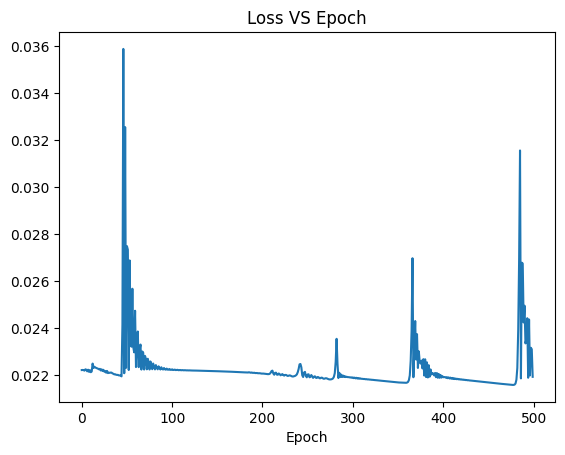

In [69]:
plt.title('Loss VS Epoch')
plt.xlabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)

In [60]:
preds = []
with torch.no_grad():
    for val in X_test_scaled:
        y_hat = model.forward(val)
        preds.append(y_scaler.inverse_transform(y_hat.detach().numpy().reshape(-1,1)))

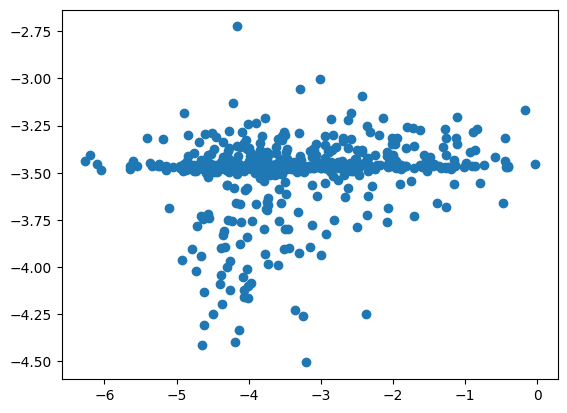

In [61]:
plt.scatter(y_test, preds)
#plt.xlim([-7,0])
#plt.ylim([-7,0])